# Install and import libraries

In [ ]:
#After having run this cell restart the runtime and then run the cell below
!pip install google-play-scraper
!pip install pyLDAvis
!pip install efficient-apriori
!pip install numpy==1.24.2
!pip install pandas==2.0.0
!pip install gensim==4.3.2

In [ ]:
import pandas as pd
import numpy as np

#GP scraper
from google_play_scraper import Sort, reviews_all

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

#data preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import string

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data colletion




## Scrape Temu USA reviews (05/11/2023)

In [ ]:
result_temu_usa = reviews_all(
    'com.einnovation.temu',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    filter_score_with=None # defaults to None(means all score)
)

# convert result_temu_usa into a df
temu_usa = pd.DataFrame(result_temu_usa)

#create a csv
temu_usa.to_csv('temu_usa.csv', index=False)

## Move csv files to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mv temu_usa.csv /content/drive/MyDrive/

# Read Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the files
temu_usa = pd.read_csv('/content/drive/MyDrive/temu_usa.csv')

# Data Manipulation

In [ ]:
# Define the 'evaluate_score' function
def evaluate_score(score):
    if 1 <= score <= 3:
        return 'negative'
    else:
        return 'positive'



def data_manipulation(df):
    # Convert 'at'
    df['at'] = pd.to_datetime(df['at'])

    # Convert 'content'
    df['content'] = df['content'].astype(str)

    # Apply 'evaluate_score' function to create a new column 'review_evaluation'
    df['review_evaluation'] = df['score'].apply(evaluate_score)

    return df

In [ ]:
# Call the function to convert columns
temu_usa = data_manipulation(temu_usa)

In [ ]:
temu_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174554 entries, 0 to 174553
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              174554 non-null  object        
 1   userName              174549 non-null  object        
 2   userImage             174554 non-null  object        
 3   content               174554 non-null  object        
 4   score                 174554 non-null  int64         
 5   thumbsUpCount         174554 non-null  int64         
 6   reviewCreatedVersion  146614 non-null  object        
 7   at                    174554 non-null  datetime64[ns]
 8   replyContent          4636 non-null    object        
 9   repliedAt             4636 non-null    object        
 10  appVersion            146614 non-null  object        
 11  review_evaluation     174554 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 16

# Explorative Data Analysis

## Total number of reviews during time

In [ ]:
# Define a function that create a new column 'year-month'
def year_month(df, date_column_name='at', new_column_name='year_month'):

    # Create a new column for the month and year as strings
    df[new_column_name] = df[date_column_name].dt.to_period('M').astype(str)

    return df

In [ ]:
# Apply the year_month function
temu_usa = year_month(temu_usa)

In [ ]:
# Group by month and count the number of reviews
monthly_reviews = temu_usa['year_month'].value_counts().sort_index().reset_index()
monthly_reviews.columns = ['Year/Month', 'Number of Reviews']

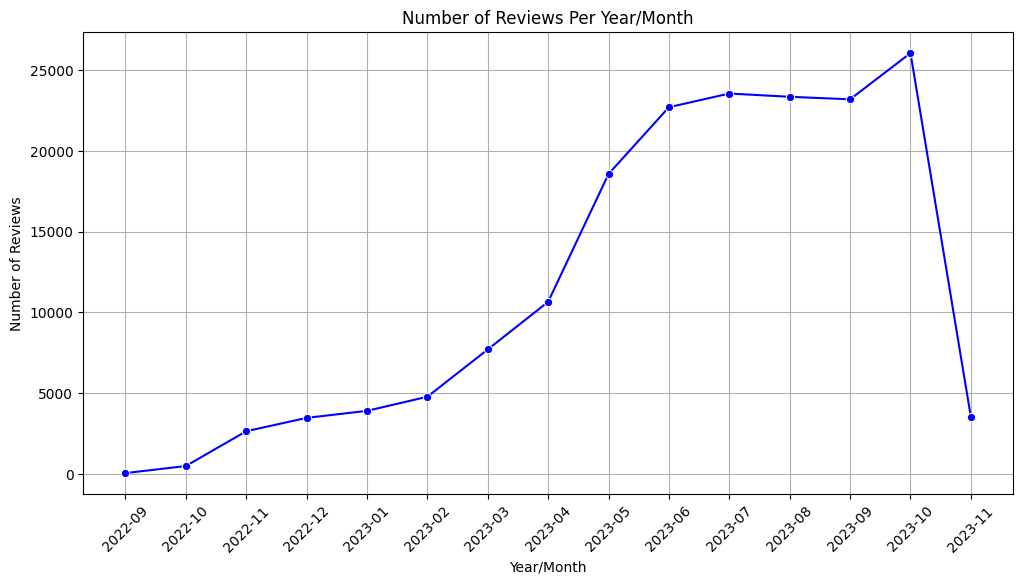

In [ ]:
# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year/Month', y='Number of Reviews', data=monthly_reviews, marker='o', color='blue')
plt.title('Number of Reviews Per Year/Month')
plt.xlabel('Year/Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Monthly Distribution of Positive and Negative Reviews

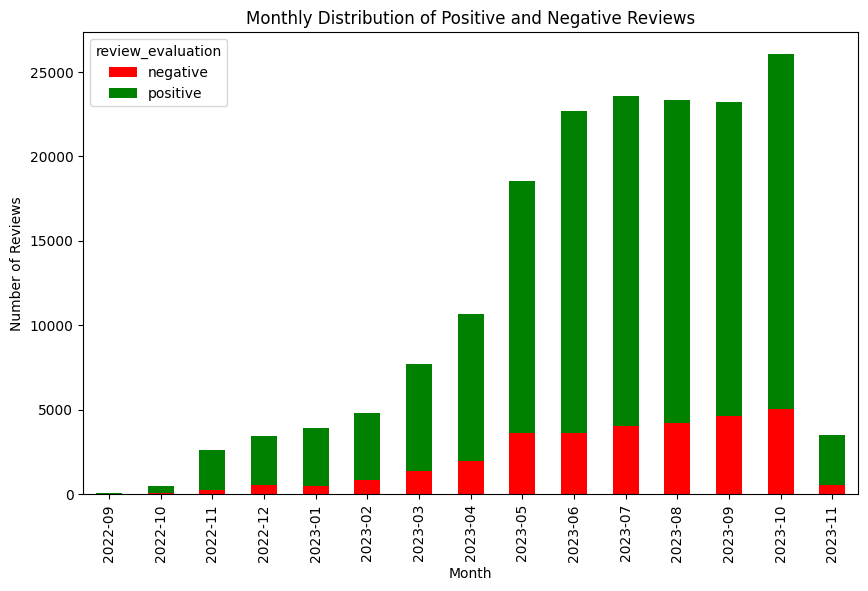

In [ ]:
# Group by 'year_month' and 'review_evaluation', then count the occurrences
review_counts = temu_usa.groupby(['year_month', 'review_evaluation']).size().unstack(fill_value=0)

# Define colors for 'negative' and 'positive'
colors = {'negative': 'red', 'positive': 'green'}

# Plot the results
ax = review_counts.plot(kind='bar', stacked=True, color=[colors[col] for col in review_counts.columns], figsize=(10, 6))
plt.title('Monthly Distribution of Positive and Negative Reviews')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# Create a table with columns for positive, negative, and total reviews for each month
table = pd.DataFrame({
    'Positive': review_counts['positive'],
    'Negative': review_counts['negative'],
    'Total': review_counts.sum(axis=1)})

table

,Positive,Negative,Total
year_month,,,
2022-09,27,21,48
2022-10,434,49,483
2022-11,2410,229,2639
2022-12,2933,532,3465
2023-01,3399,501,3900
2023-02,3960,813,4773
2023-03,6358,1344,7702
2023-04,8693,1957,10650
2023-05,14918,3645,18563


## Number of reviews per time slot

In [ ]:
# Define a function that classify time slots (morning, afternoon, evening, night) of the reviews
def time_slot(df, timestamp_column):

    # Define time slots
    morning = (df[timestamp_column].dt.hour >= 6) & (df[timestamp_column].dt.hour < 12)
    afternoon = (df[timestamp_column].dt.hour >= 12) & (df[timestamp_column].dt.hour < 18)
    evening = (df[timestamp_column].dt.hour >= 18) & (df[timestamp_column].dt.hour < 24)
    night = (df[timestamp_column].dt.hour >= 0) & (df[timestamp_column].dt.hour < 6)

    # Create a new column 'time_slot'
    df['time_slot'] = pd.cut(df[timestamp_column].dt.hour, bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], include_lowest=True)

    return df

In [ ]:
# Apply the time slot function
temu_usa = time_slot(temu_usa, 'at')

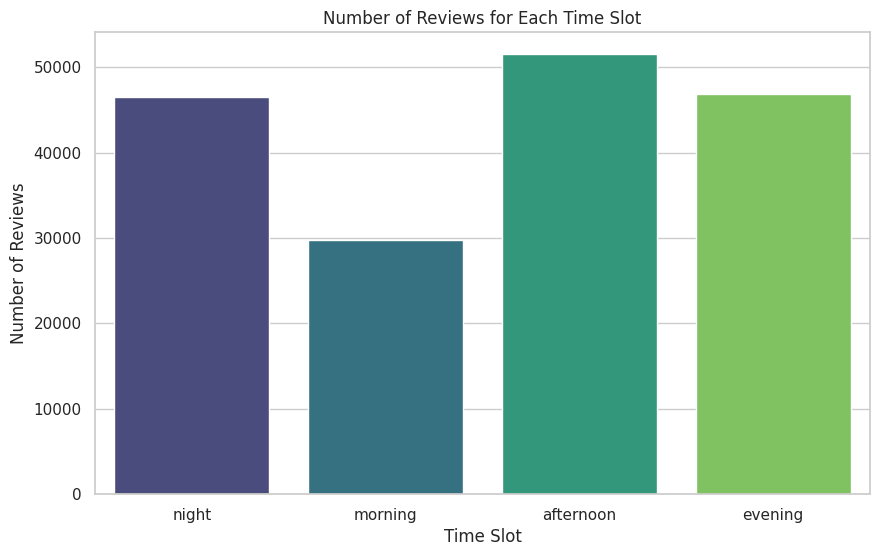

In [ ]:
# Create a bar plot for the number of reviews for each time slot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='time_slot', data=temu_usa, palette="viridis")
plt.xlabel('Time Slot')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each Time Slot')
plt.show()

## Reviews Score Distribution

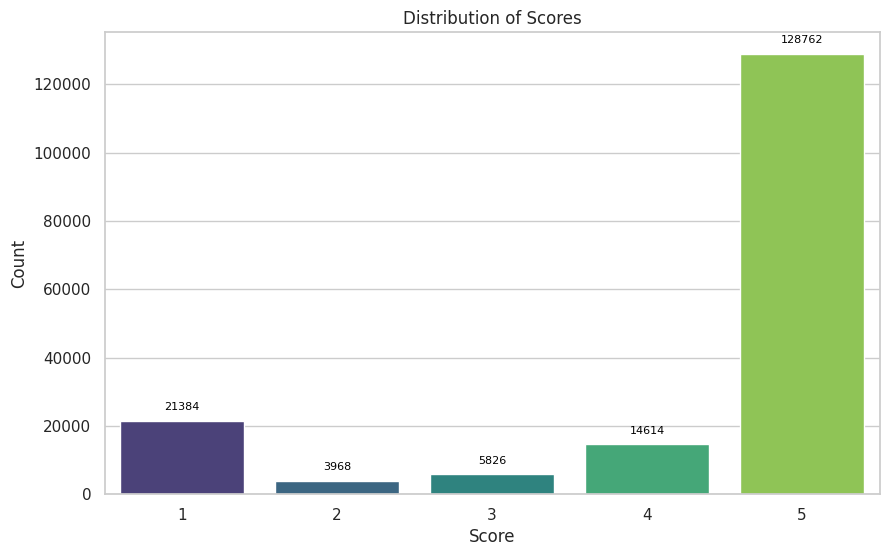

In [ ]:
# Plot the score distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='score', data=temu_usa, palette='viridis')

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8, color='black')

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Data Cleaning and Preprocessing

Data Cleaning

In [ ]:
# Define the 'remove_columns' function that removes useless columns

def remove_columns(df, columns_to_remove):

    df = df.drop(columns=columns_to_remove, axis=1)

    return df

In [ ]:
#Columns to remove
columns_to_remove = ['reviewId', 'userName', 'userImage', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'time_slot']

# Call the function to remove columns
temu_usa = remove_columns(temu_usa, columns_to_remove)

In [ ]:
temu_usa.head()

,content,review_evaluation,year_month
0,Temu is a mostly good and intuitive app. Price...,positive,2023-10
1,Great app. It's like Amazon but with cheaper p...,positive,2023-10
2,I was really concerned about purchasing anythi...,positive,2023-11
3,"It's a good app, haven't had any problems when...",positive,2023-10
4,I'm pretty sure this apps sales tactics are il...,negative,2023-10


Data Preprocessing




In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if the part of speech is not recognized

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenize and tag the text with parts of speech
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Remove punctuation, non-word tokens and stopwords, and lemmatize the tokens
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags if token not in string.punctuation and token not in stop_words and token.isalpha()]

    # Remove specific words
    specific_words = ["e", "thank", "absolutely", "sure", "mostly", "always", "et", "e", "never", "yet", "please", "one",
             "yeah", "idk", "con", "al", "b", "k", "u", "ever", "totally", "c", "w", "se", "I", "nan", "ca", "nag", "fab",
             "och", "unbelievable", "alright", "see", "constantly", "de", "muy", "la", "que", "en", "buena",
             "los", "excelente", "lo", "el", "todo", "productos", "mi", "precios", "un", "para", "calidad",
             "una", "aplicación", "buenos", "te", "bien", "bueno", "recomiendo", "tiempo", "comprar"]

    tokens = [token for token in tokens if token not in specific_words]

    return tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Apply the 'preprocess_text' to the 'content' column and create a new column 'preprocessed_content'
temu_usa['preprocessed_content'] = temu_usa['content'].apply(preprocess_text)

In [ ]:
temu_usa['content'].iloc[0]

"Temu is a mostly good and intuitive app. Prices and items are surprisingly good. It's been great so far with the many orders that I've placed and the shipping has always been within the estimates for arrival! However, I am deducting a star because they got rid of the wishlist without explaining why, so the only way to save items is to add them to your cart. That's disappointing."

In [ ]:
temu_usa['preprocessed_content'].iloc[0]

['temu',
 'good',
 'intuitive',
 'app',
 'price',
 'item',
 'surprisingly',
 'good',
 'great',
 'far',
 'many',
 'order',
 'place',
 'shipping',
 'within',
 'estimate',
 'arrival',
 'however',
 'deduct',
 'star',
 'get',
 'rid',
 'wishlist',
 'without',
 'explain',
 'way',
 'save',
 'item',
 'add',
 'cart',
 'disappointing']

# Topic Modeling

In [ ]:
# Define a function that creates a dictionary and a corpus

def dictionary_corpus(df, text_column):
    # Create Dictionary
    id2word = corpora.Dictionary(df[text_column])

    # Create Corpus
    texts = df[text_column]

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    return id2word, texts, corpus

In [ ]:
# Call the 'dictionary_corpus' function
temu_id2word, temu_texts, temu_corpus = dictionary_corpus(temu_usa, 'preprocessed_content')

In [ ]:
# print an example of corpus
print(temu_corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(temu_id2word[id], freq) for id, freq in cp] for cp in temu_corpus[:1]]

[[('add', 1),
  ('app', 1),
  ('arrival', 1),
  ('cart', 1),
  ('deduct', 1),
  ('disappointing', 1),
  ('estimate', 1),
  ('explain', 1),
  ('far', 1),
  ('get', 1),
  ('good', 2),
  ('great', 1),
  ('however', 1),
  ('intuitive', 1),
  ('item', 2),
  ('many', 1),
  ('order', 1),
  ('place', 1),
  ('price', 1),
  ('rid', 1),
  ('save', 1),
  ('shipping', 1),
  ('star', 1),
  ('surprisingly', 1),
  ('temu', 1),
  ('way', 1),
  ('wishlist', 1),
  ('within', 1),
  ('without', 1)]]

# Hyperparameter Tuning

In [ ]:
# Define a function that computes c_v coherence for various numbers of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various numbers of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    start : Min num of topics
    limit : Max num of topics
    step : Step size for the number of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"\nTraining LDA model with {num_topics} topics...")
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=123,
                                           chunksize=100,
                                           passes=10)


        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Coherence value for {num_topics} topics: {coherencemodel.get_coherence()}")

    return model_list, coherence_values

## Temù Coherence values

In [ ]:
# Temu model list and coherence values
temu_model_list, temu_coherence_values = compute_coherence_values(dictionary=temu_id2word, corpus=temu_corpus, texts=temu_texts, start=2, limit=10, step=1)


Training LDA model with 2 topics...
Coherence value for 2 topics: 0.47130670209153347

Training LDA model with 3 topics...
Coherence value for 3 topics: 0.4947196438858761

Training LDA model with 4 topics...
Coherence value for 4 topics: 0.4765197444406982

Training LDA model with 5 topics...
Coherence value for 5 topics: 0.44617688439206366

Training LDA model with 6 topics...
Coherence value for 6 topics: 0.4286070514719385

Training LDA model with 7 topics...
Coherence value for 7 topics: 0.4639901160658694

Training LDA model with 8 topics...
Coherence value for 8 topics: 0.4133910490630932

Training LDA model with 9 topics...
Coherence value for 9 topics: 0.4401114674621025


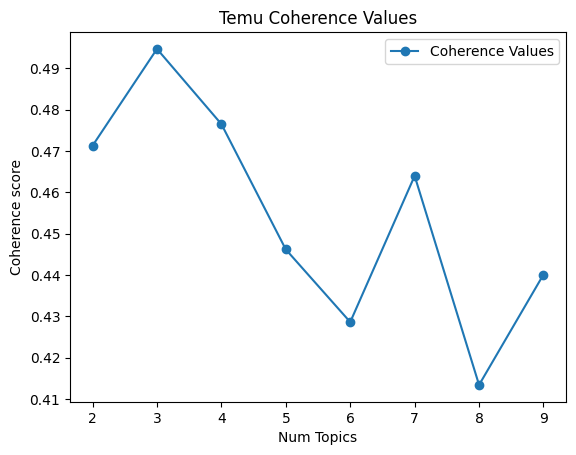

In [ ]:
# Plot the coherence values
limit = 10
start = 2
step = 1

x = range(start, limit, step)
plt.plot(x,temu_coherence_values, marker='o', label='Coherence Values')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Temu Coherence Values')
plt.legend()
plt.show()

## Temù LDA model (3 topics)

In [ ]:
# LDA model for 3 topics
temu_lda_model_3 = gensim.models.LdaMulticore(corpus=temu_corpus,
                                       id2word=temu_id2word,
                                       num_topics=3,
                                       random_state=123,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True
                                       )

In [ ]:
from pprint import pprint

# Print the Keyword in the 3 topics
pprint(temu_lda_model_3.print_topics())
doc_lda = temu_lda_model_3[temu_corpus]

[(0,
  '0.090*"scam" + 0.027*"ok" + 0.025*"bad" + 0.024*"like" + 0.018*"fake" + '
  '0.014*"suck" + 0.011*"app" + 0.010*"trash" + 0.008*"spyware" + '
  '0.008*"horrible"'),
 (1,
  '0.169*"great" + 0.158*"love" + 0.076*"app" + 0.062*"awesome" + '
  '0.045*"excellent" + 0.034*"temu" + 0.026*"price" + 0.024*"amaze" + '
  '0.022*"product" + 0.016*"service"'),
 (2,
  '0.219*"good" + 0.056*"nice" + 0.016*"item" + 0.012*"perfect" + '
  '0.008*"everything" + 0.008*"work" + 0.006*"really" + 0.006*"beautiful" + '
  '0.006*"happy" + 0.005*"order"')]


In [ ]:
# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
temu_vis_data_3 = gensimvis.prepare(temu_lda_model_3, temu_corpus,temu_id2word)
pyLDAvis.display(temu_vis_data_3)

## Temù LDA model (4 topics)

In [ ]:
# LDA model for 4 topics
temu_lda_model_4 = gensim.models.LdaMulticore(corpus=temu_corpus,
                                       id2word=temu_id2word,
                                       num_topics=4,
                                       random_state=123,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True
                                       )

In [ ]:
from pprint import pprint

# Print the Keyword in the 4 topics
pprint(temu_lda_model_4.print_topics())
doc_lda = temu_lda_model_4[temu_corpus]

[(0,
  '0.041*"like" + 0.030*"cool" + 0.027*"cheap" + 0.013*"spyware" + '
  '0.012*"junk" + 0.010*"wish" + 0.009*"spam" + 0.008*"temu" + 0.008*"get" + '
  '0.008*"chinese"'),
 (1,
  '0.187*"great" + 0.174*"love" + 0.085*"app" + 0.069*"awesome" + '
  '0.050*"excellent" + 0.036*"temu" + 0.029*"price" + 0.026*"amaze" + '
  '0.018*"service" + 0.015*"product"'),
 (2,
  '0.344*"good" + 0.088*"nice" + 0.031*"quality" + 0.025*"item" + '
  '0.021*"product" + 0.018*"perfect" + 0.015*"experience" + 0.013*"everything" '
  '+ 0.010*"really" + 0.009*"happy"'),
 (3,
  '0.112*"scam" + 0.035*"ok" + 0.032*"bad" + 0.022*"fake" + 0.018*"suck" + '
  '0.016*"stuff" + 0.013*"trash" + 0.010*"app" + 0.010*"horrible" + '
  '0.009*"garbage"')]


In [ ]:
# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
temu_vis_data_4 = gensimvis.prepare(temu_lda_model_4, temu_corpus,temu_id2word)
pyLDAvis.display(temu_vis_data_4)


#1) Security concerns: [spyware, malware, intrusive, steal, fraud, cheap, Chinese, data]
#2) Product Quality: [quality, merchandise, lovely, fit, size, perfect, purchase, item]
#3) Shopping Experience:[app, deal, service, fast, delivery, addictive, shipping, price,site, shopping, store]
#4) Advertising: [advertising,pyramid,real,false,fake,scheme,legit,scammer,free]

# Association Rules Mining

In [ ]:
from efficient_apriori import apriori
from nltk.probability import FreqDist

In [ ]:
temu_usa.head()

,content,review_evaluation,year_month,preprocessed_content
0,Temu is a mostly good and intuitive app. Price...,positive,2023-10,"[temu, good, intuitive, app, price, item, surp..."
1,Great app. It's like Amazon but with cheaper p...,positive,2023-10,"[great, app, like, amazon, cheap, price, yes, ..."
2,I was really concerned about purchasing anythi...,positive,2023-11,"[really, concern, purchase, anything, read, de..."
3,"It's a good app, haven't had any problems when...",positive,2023-10,"[good, app, problem, place, order, sizing, iff..."
4,I'm pretty sure this apps sales tactics are il...,negative,2023-10,"[pretty, apps, sale, tactic, illegal, app, tel..."


In [ ]:
# Extracts the most frequent words and their counts from a specified column in a df
def extract_top_words(df, column_name, top_n=500):
    """
    Parameters:
        df (pd.DataFrame): The DataFrame containing the column with tokenized content.
        column_name (str): The name of the column with tokenized content.
        top_n (int): The number of top words to extract. Default is 1000.

    Returns:
        pd.DataFrame: A DataFrame with two columns - 'Word' and 'Count'.
    """
    # Extract tokens from the specified column
    all_tokens = [token for tokens_list in df[column_name] for token in tokens_list]

    # Calculate word frequencies
    freq_dist = FreqDist(all_tokens)

    # Get the top N frequent words and their counts
    top_words_and_counts = freq_dist.most_common(top_n)

    # Create a DataFrame for top words and their counts
    top_words_df = pd.DataFrame(top_words_and_counts, columns=['Keyword', 'Count'])

    return top_words_df

In [ ]:
# Apply the function to 'temu_usa'
top_words_temu_usa = extract_top_words(temu_usa, 'preprocessed_content')
top_words_temu_usa

,Keyword,Count
0,great,40182
1,love,39934
2,good,39623
3,app,33553
4,order,33315
...,...,...
495,line,363
496,appreciate,363
497,include,362
498,surprised,362


In [ ]:
# Classify keywords to their most similar e-commerce feature
General = ['great', 'love', 'good', 'temu', 'get', 'everything', 'like', 'really', 'use',
           'make', 'give', 'would', 'well', 'come', 'happy', 'say', 'excellent', 'awesome', 'go', 'much', 'take', 'place', 'find',
           'wish', 'lot', 'first', 'need', 'nice', 'many', 'want', 'people', 'look', 'best', 'day', 'keep', 'even', 'work',
           'think', 'anything', 'way', 'company', 'friend', 'also', 'know', 'week', 'new', 'every', 'amaze', 'definitely', 'win', 'expect',
           'something', 'could', 'true', 'tell', 'little', 'still', 'long', 'pretty', 'thanks', 'amazing', 'back', 'highly', 'fun', 'star',
           'enjoy', 'pleased', 'fantastic', 'reasonable', 'right', 'nothing', 'actually', 'super', 'addict', 'cool',
           'everyone', 'seem', 'brilliant', 'read', 'big', 'exactly', 'wonderful', 'stop', 'start', 'let', 'waste', 'bit',  'within',
           'month', 'satisfied', 'different', 'already', 'wo', 'overall', 'continue', 'put', 'family', 'another', 'two',
           'almost', 'last', 'less', 'away', 'else', 'date', 'choose', 'hard', 'impressed', 'high', 'plus',
           'point', 'ok', 'lol', 'alot', 'though', 'others', 'ask', 'beautiful', 'guy', 'feel', 'couple', 'surprise', 'sometimes',
           'however', 'top', 'end', 'change', 'since', 'dont', 'favorite', 'beat', 'enough', 'especially', 'next',
           'quite', 'choice', 'able', 'leave', 'n', 'cute', 'anyone', 'usually', 'satisfy', 'may', 'extremely', 'do',
           'glad', 'believe', 'part', 'business', 'around', 'christmas', 'bag', 'im', 'close', 'hope', 'impossible', 'run',
           'text', 'least', 'soon', 'second', 'etc', 'l',  'number', 'yes', 'kind', 'either', 'full', 'hate',
            'someone', 'live', 'reason', 'must', 'minimum', 'chance', 'complete', 'lovely', 'stay', 'whole', 'load', 'person',
           'due', 'later', 'literally', 'na', 'fine', 'might', 'half', 'fair', 'honestly', 'open', 'instead', 'join',
           'home', 'today', 'multiple', 'job', 'kid', 'happen', 'life', 'except', 'cent', 'range', 'anywhere', 'huge', 'total', 'three',
           'bring', 'hit', 'fact', 'state', 'unless', 'probably', 'mean', 'maybe', 'refer', 'pop', 'ive', 'country', 'suppose',
           'ton', 'ur', 'year', 'wow', 'pleasantly', 'forever', 'expectation', 'future', 'cause', 'word', 'manner', 'completely', 'bunch',
           'matter', 'okay', 'often', 'accept', 'truly', 'trash', 'wear', 'twice', 'ebay', 'personal', 'extra', 'compare', 'fault',
           'become', 'cant', 'budget', 'tracking', 'honest', 'fee', 'hear', 'gon', 'mind', 'similar', 'name', 'rate',
           'single', 'fabulous', 'house', 'five', 'short', 'allow', 'minute', 'exceptional', 'constant', 'pair', 'reach', 'cut',
           'appreciate', 'include', 'surprised','without','rip', 'hour']

Product = ['item', 'quality', 'product', 'size', 'clothes', 'value', 'bad', 'worth', 'fit', 'perfect', 'clothing', 'merchandise', 'shoe',
            'selection', 'description', 'decent', 'material', 'described', 'box', 'describe', 'shirt', 'poor', 'jewelry', 'packaging',
            'condition', 'dress', 'pack', 'set', 'gadget', 'detail', 'color', 'cheaply', 'rig', 'photo', 'hook', 'stock', 'accurate',
            'line','thing', 'stuff','variety', 'watch','small','several','large','wide','list' 'useful']
Security = ['scam', 'fake', 'account', 'user', 'email', 'information', 'china', 'steal', 'lie', 'info', 'legit', 'fish', 'charge',
            'trust', 'data', 'chinese', 'sign', 'bank', 'junk', 'fishland', 'false', 'address', 'spam', 'beware']
Shopping = ['app','order', 'price', 'time', 'delivery', 'buy', 'fast', 'shipping', 'cheap', 'service', 'shop', 'purchase', 'receive', 'shopping',
            'easy', 'deal', 'customer', 'quick', 'try', 'arrive', 'ship', 'pay', 'return', 'store', 'deliver', 'package', 'problem', 'low',
            'affordable', 'refund', 'credit', 'send', 'wait', 'download', 'experience', 'offer', 'issue', 'amazon', 'spend', 'online',
            'discount', 'sell', 'check', 'website', 'coupon', 'quickly', 'dollar', 'save', 'card', 'phone', 'disappoint', 'bargain',
            'update', 'notification', 'cost', 'wrong', 'help', 'option', 'track', 'miss', 'delete', 'apps', 'amount', 'cart', 'complaint',
            'sale', 'break', 'timely', 'annoy', 'buying', 'damage', 'care', 'lose', 'search', 'available', 'slow', 'support', 'wishlist',
            'pricing', 'turn', 'contact', 'process', 'pick', 'reliable', 'fix', 'careful', 'horrible', 'inexpensive', 'call', 'suck',
            'aliexpress', 'shein', 'click', 'switch', 'terrible', 'expensive', 'communication', 'shipment', 'disappointed', 'post',
            'prompt', 'garbage', 'parcel', 'immediately', 'policy', 'helpful', 'install', 'postage', 'trash', 'fault', 'tracking',
            'fee', 'cash', 'navigate', 'payment', 'seller', 'cancel', 'instal', 'stupid', 'remove','far', 'site', 'late', 'early','faster',
            'money', 'gift']
Advertising = ['recommend', 'invite', 'review', 'ad', 'add', 'show', 'share', 'addictive', 'reward', 'prize', 'promise', 'earn',
               'link', 'advertising', 'advertise', 'claim', 'promotion', 'advertised', 'referral', 'free', 'picture',
               'skeptical','spin', 'billionaire','game','play','message']

In [ ]:
# Define a dictionary where keys are category names and values are lists of words for each category
categories = {
    'Product': ['item', 'quality', 'product', 'size', 'clothes', 'value', 'bad', 'worth', 'fit', 'perfect', 'clothing', 'merchandise', 'shoe',
                'selection', 'description', 'decent', 'material', 'described', 'box', 'describe', 'shirt', 'poor', 'jewelry', 'packaging',
                'condition', 'dress', 'pack', 'set', 'gadget', 'detail', 'color', 'cheaply', 'rig', 'photo', 'hook', 'stock', 'accurate',
                'line', 'thing', 'stuff', 'variety', 'watch', 'small', 'several', 'large', 'wide', 'list', 'useful'],

    'Security': ['scam', 'fake', 'account', 'user', 'email', 'information', 'china', 'steal', 'lie', 'info', 'legit', 'fish', 'charge',
                'trust', 'data', 'chinese', 'sign', 'bank', 'junk', 'fishland', 'false', 'address', 'spam', 'beware'],

    'Shopping': ['app', 'order', 'price', 'time', 'delivery', 'buy', 'fast', 'shipping', 'cheap', 'service', 'shop', 'purchase', 'receive', 'shopping',
                 'easy', 'deal', 'customer', 'quick', 'try', 'arrive', 'ship', 'pay', 'return', 'store', 'deliver', 'package', 'problem', 'low',
                 'affordable', 'refund', 'credit', 'send', 'wait', 'download', 'experience', 'offer', 'issue', 'amazon', 'spend', 'online',
                 'discount', 'sell', 'check', 'website', 'coupon', 'quickly', 'dollar', 'save', 'card', 'phone', 'disappoint', 'bargain',
                 'update', 'notification', 'cost', 'wrong', 'help', 'option', 'track', 'miss', 'delete', 'apps', 'amount', 'cart', 'complaint',
                 'sale', 'break', 'timely', 'annoy', 'buying', 'damage', 'care', 'lose', 'search', 'available', 'slow', 'support', 'wishlist',
                 'pricing', 'turn', 'contact', 'process', 'pick', 'reliable', 'fix', 'careful', 'horrible', 'inexpensive', 'call', 'suck',
                 'aliexpress', 'shein', 'click', 'switch', 'terrible', 'expensive', 'communication', 'shipment', 'disappointed', 'post',
                 'prompt', 'garbage', 'parcel', 'immediately', 'policy', 'helpful', 'install', 'postage', 'trash', 'fault', 'tracking',
                 'fee', 'cash', 'navigate', 'payment', 'seller', 'cancel', 'instal', 'stupid', 'remove', 'far', 'site', 'late', 'early', 'faster',
                 'money', 'gift'],

    'Advertising': ['recommend', 'invite', 'review', 'ad', 'add', 'show', 'share', 'addictive', 'reward', 'prize', 'promise', 'earn',
                    'link', 'advertising', 'advertise', 'claim', 'promotion', 'advertised', 'referral', 'free', 'picture',
                    'skeptical', 'spin', 'billionaire', 'game', 'play', 'message']
}

In [ ]:
# Define the function 'categorize_content' that adds a column 'features' that contains the features of each review
def categorize_content(df, categories, content_column='preprocessed_content'):
    """
    Parameters:
        df (pd.DataFrame): The DataFrame containing the 'preprocessed_content' column.
        categories (dict): A dictionary where keys are category names and values are lists of words for each category.
        content_column (str): The name of the column with preprocessed content. Default is 'preprocessed_content'.

    Returns:
        pd.DataFrame: The original DataFrame with a new 'features' column containing a list of features present.
    """
    # Add 'features'
    df['features'] = df[content_column].apply(lambda tokens: [category for category, category_words in categories.items() if any(word in tokens for word in category_words)])

    return df


# Apply the categorization function
temu_usa = categorize_content(temu_usa, categories)

In [ ]:
# Drop all the rows where the 'features' column is an empty list
temu_usa.drop(temu_usa[temu_usa['features'].apply(len) == 0].index, inplace=True)

# Reset the indexes
temu_usa.reset_index(drop=True, inplace=True)

In [ ]:
temu_usa

,content,review_evaluation,year_month,preprocessed_content,features
0,Temu is a mostly good and intuitive app. Price...,positive,2023-10,"[temu, good, intuitive, app, price, item, surp...","[Product, Shopping, Advertising]"
1,Great app. It's like Amazon but with cheaper p...,positive,2023-10,"[great, app, like, amazon, cheap, price, yes, ...","[Product, Shopping, Advertising]"
2,I was really concerned about purchasing anythi...,positive,2023-11,"[really, concern, purchase, anything, read, de...","[Product, Shopping, Advertising]"
3,"It's a good app, haven't had any problems when...",positive,2023-10,"[good, app, problem, place, order, sizing, iff...","[Product, Shopping]"
4,I'm pretty sure this apps sales tactics are il...,negative,2023-10,"[pretty, apps, sale, tactic, illegal, app, tel...","[Product, Shopping]"
...,...,...,...,...,...
143534,W website,positive,2023-07,[website],[Shopping]
143535,Beat site,positive,2023-10,"[beat, site]",[Shopping]
143536,Addicting store,positive,2023-07,"[addict, store]",[Shopping]
143537,AAAPlus service,positive,2023-09,"[aaaplus, service]",[Shopping]


In [ ]:
# Create a new df with only 'features' and 'review_evaluation' columns
df = temu_usa[['features', 'review_evaluation']]
df.head()

,features,review_evaluation
0,"[Product, Shopping, Advertising]",positive
1,"[Product, Shopping, Advertising]",positive
2,"[Product, Shopping, Advertising]",positive
3,"[Product, Shopping]",positive
4,"[Product, Shopping]",negative


In [ ]:
# Transform the df in tuples
transactions = [tuple(row) for row in df.values.tolist()]

# Extract the lists of items and labels from each tuple
transaction_items = [tuple(transaction[0]) for transaction in transactions]
transaction_labels = [transaction[1] for transaction in transactions]

# Combine items and labels to form transactions for apriori
labeled_transactions = list(zip(transaction_items, transaction_labels))

# Convert itemsets to strings
labeled_transactions = [(str(items), label) for items, label in labeled_transactions]

# Apply apriori to generate rules
itemsets, rules = apriori(labeled_transactions, min_support = 0.001)

In [ ]:
# Get the rules sorted by lift in descending order
for rule in sorted(rules, key=lambda rule: rule.lift, reverse=True):
    print(rule)

{('Security', 'Advertising')} -> {negative} (conf: 0.883, supp: 0.002, lift: 4.599, conv: 6.888)
{('Security', 'Shopping', 'Advertising')} -> {negative} (conf: 0.839, supp: 0.013, lift: 4.370, conv: 5.013)
{('Security',)} -> {negative} (conf: 0.834, supp: 0.010, lift: 4.347, conv: 4.878)
{('Security', 'Shopping')} -> {negative} (conf: 0.726, supp: 0.019, lift: 3.784, conv: 2.952)
{('Product', 'Security', 'Shopping', 'Advertising')} -> {negative} (conf: 0.686, supp: 0.023, lift: 3.576, conv: 2.577)
{('Product', 'Security')} -> {negative} (conf: 0.618, supp: 0.001, lift: 3.220, conv: 2.116)
{('Product', 'Shopping')} -> {positive} (conf: 0.918, supp: 0.321, lift: 1.136, conv: 2.331)
{('Product',)} -> {positive} (conf: 0.900, supp: 0.059, lift: 1.114, conv: 1.928)
{('Shopping',)} -> {positive} (conf: 0.886, supp: 0.277, lift: 1.096, conv: 1.682)
{('Product', 'Shopping', 'Advertising')} -> {positive} (conf: 0.778, supp: 0.072, lift: 0.963, conv: 0.864)
{('Product', 'Advertising')} -> {posit